In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import glob
import pandas as pd
from collections import OrderedDict

In [8]:
#directories = glob.glob('.experiments/kinova-2d-planar/*/*/result*.pth')
directories = glob.glob('.experiments/kinova-camera-2d-planar/*/*/result*.pth')
#load each 
results = {}
seed = 0
is_one_model = False
for pth in directories:
    dt = pth.split('/')[-1].split('-dt-')[-1].split('-')[0]
    algorithm = pth.split('/')[2] + '-' + dt
    
    result = torch.load(pth)
    if algorithm in results and not is_one_model:
        start = len(results[algorithm])
        end = len(results[algorithm]) + len(result)
        j = 0
        for i in range(start, end):
            results[algorithm][i] = result[j]
            j += 1        
    elif algorithm in results and is_one_model:
        results[algorithm + "-" + str(seed)] = result
        seed += 1
    else:
        results[algorithm] = result
    

In [9]:
results.keys()

dict_keys(['broyden-results', 'multitask-knn-neuraljacobian-custom-results', 'blackbox-kinematics-custom-results', 'local-uvs-results', 'knn-neuraljacobian-custom-results', 'global-locallinear-kd-k-10-results', 'global-locallinear-kd-results'])

In [10]:
labels = [
            #("inversejacobian", "True Jacobian"),
              ("local-uvs-results", "Finite Difference"),
                ("broyden-results", "Broyden"),
            ("global-locallinear-kd-results", "KNN Local Linear"),
          ("blackbox-kinematics-custom-results", "Neural Kinematics"),
          ("knn-neuraljacobian-custom-results", "KNN Neural Jacobian"),
          ("multitask-knn-neuraljacobian-custom-results", "Bi-KNN Neural Jacobian")
         ]
labels = OrderedDict(labels)
new_results = []
for label in labels:
    for k in results.keys():
        if label in k:
            print(k, label)
            new_results.append([labels[label], results[k]])
            
results = new_results

results = OrderedDict(new_results)



local-uvs-results local-uvs-results
broyden-results broyden-results
global-locallinear-kd-results global-locallinear-kd-results
blackbox-kinematics-custom-results blackbox-kinematics-custom-results
multitask-knn-neuraljacobian-custom-results knn-neuraljacobian-custom-results
knn-neuraljacobian-custom-results knn-neuraljacobian-custom-results
multitask-knn-neuraljacobian-custom-results multitask-knn-neuraljacobian-custom-results


In [11]:
results.keys()

odict_keys(['Finite Difference', 'Broyden', 'KNN Local Linear', 'Neural Kinematics', 'KNN Neural Jacobian', 'Bi-KNN Neural Jacobian'])

# Plot Error Curves
In this section we want to see if our Jacobian estimates with our neural network actually solve the undlerying task of interest (i.e. moving the end effector to some target position)

In [12]:
def collect_eps_errs(result, dim=-1):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            state = v[5] #should be....state
            if dim < 0:
                psn = state[0:2]
                targ = state[-2:]
                mse = np.linalg.norm(targ - psn, 2)
                rmse = np.sqrt(mse)
                
                #mse = rmse
            else:
                psn = state[dim]
                targ = state[-3 + dim]
                mse = np.sqrt((targ - psn) ** 2)
            episode_err.append(mse)
        err_over_time.append(episode_err)
    return np.array(err_over_time).T

def plot_mu_sig(data, label=None, axis=1, ax=None,line_stype='b-'):
    samples = np.array(data)
    mean = samples.mean(axis=axis)
    std = samples.std(axis=axis)
    ste = std / np.sqrt(samples.shape[0]) #this is a hack, if axis not == 1, this will break
    
    if ax is None:
        plt.plot(mean, line_stype, label=label)
        plt.fill_between(list(range(mean.shape[0])), mean + std, mean - std, alpha=0.1)
    else:
        ax.plot(mean,line_stype, label=label)
        #ax.errorbar(list(range(mean.shape[0])), mean, yerr=std /np.sqrt(samples.shape[0]) , label=label)
        ax.fill_between(list(range(mean.shape[0])), mean + ste, mean - ste, color=line_stype[0], alpha=0.1)

In [13]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time

In [44]:


line_types = [
            #("True Jacobian", "b|-"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
            ("KNN Local Linear", "g--"),
          ("Neural Kinematics", "m-"),
          ("KNN Neural Jacobian", "y:"),
          ("Bi-KNN Neural Jacobian", "k--")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['Broyden', 'Finite Difference', 'KNN Local Linear', 'Neural Kinematics', 'KNN Neural Jacobian', 'Bi-KNN Neural Jacobian'])

37
37
37
37
37
37
39
39
39
39
39
39
21
21
21
21
21
21


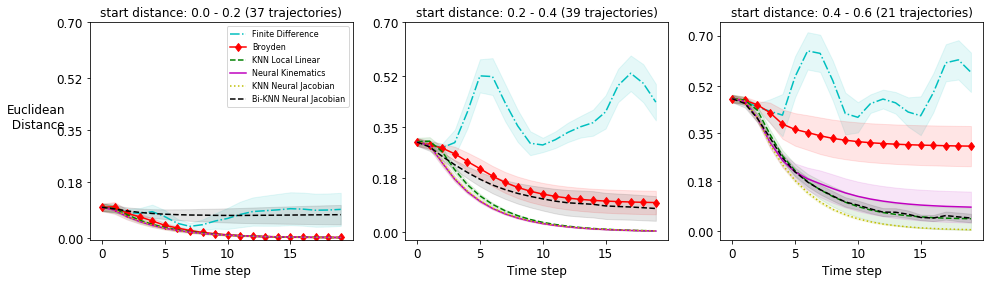

In [52]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
#bounds = [0.0, .33, .66, 1.0] #, 1.5]
#bounds = [0.0, .25, .5, .75]
bounds = [0.0, .20, .40, .60]
n_plts = len(bounds) - 1
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        print(to_plot.sum())
        num_trajs = np.sum(to_plot)
        line_type = line_types[algorithm]
        plot_mu_sig(err_over_time[0:200:10, to_plot], label=algorithm, ax=ax, line_stype=line_type)
    
    
    #ax.get_yaxis().set_ticks(np.round(np.linspace(0.0, end, 5), 2))
    ax.get_yaxis().set_ticks(np.round(np.linspace(0.0, 0.7, 5), 2))
    if i == 0:
        ax.legend()
    ax.set_title("start distance: {} - {} ({} trajectories)".format(start, end,num_trajs))
    i += 1
    if i == 1:
        ax.set_ylabel("Euclidean\n Distance", rotation=0, fontsize=12, labelpad=20)
        #h = plt.ylabel('Overall\n average\n return', labelpad=20)
        #h.set_rotation(0)
    
    ax.set_xlabel("Time step")
    #else:
    #    ax.get_xaxis().set_ticks([])
        
    
plt.savefig('robo_error_curves.pdf',bbox_inches = 'tight',
    pad_inches = 0.1) 

# Visualising start and end points for Trajectories

In this section we visualize the starting position against the end position. The intention of these plots is to understand how distance to the target might affect convergence

# Violin Plots of End Performance

In this section we focus on the performance at the end of each episode. specifically whether or not the target was reached

In [32]:

violin_results = []
for algorithm, result in results.items():
    print(algorithm)
    err_over_time = collect_eps_errs(result, dim=-1)
    violin_results.append([algorithm, err_over_time])
    
violin_results = OrderedDict(violin_results)

Finite Difference
Broyden
KNN Local Linear
Neural Kinematics
KNN Neural Jacobian
Bi-KNN Neural Jacobian


# These are just tables of statistics from the trajectories 
The basic question is whether or not they reached the target. 
We considered the target reached by some threshold


In [20]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time

In [34]:
#bounds = [0.0, .33, .66, 1.0]
#bounds = [0.0, .25, .5, .75]
bounds = [0.0, .20, .40, .60]
successTable = {}

for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        to_plot = np.logical_and(to_plot, err_over_time[-1,:] <= .1)
        percentage = to_plot.sum() / count[-1] * 100.0 #so it's between 0 - 100%
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in successTable:
            successTable[algorithm] = {"{}m - {}m".format(low,high): percentage}
        else:
            successTable[algorithm]["{}m - {}m".format(low,high)] = percentage
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    succeses = (err_over_time[-1,:] <= .1)
    percentage = succeses.sum() / err_over_time.shape[1] * 100.0 #so it's between 0 - 100%
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in successTable:
            successTable[algorithm] = {"Overall": percentage}
    else:
        successTable[algorithm]["Overall"] = percentage
    
successTable = pd.DataFrame.from_dict(successTable).round(2).transpose()
successTable

,0.0m - 0.2m,0.2m - 0.4m,0.4m - 0.6m,Overall
Bi-KNN Neural Jacobian,83.78,89.74,85.71,85.0
Broyden,100.00,76.92,52.38,78.0
Finite Difference,89.19,12.82,9.52,40.0
KNN Local Linear,100.00,100.00,95.24,96.0
KNN Neural Jacobian,100.00,100.00,100.00,97.0
Neural Kinematics,100.00,100.00,90.48,95.0


In [35]:
successesTable = {}
count = []
step_size = 0.001
highest = 0.1
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        range_to_thresh = np.arange(0, highest, 0.001)
        for thresh in range_to_thresh:
            success = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)

            percentage = success.sum() / count[-1] * 100.0 #so it's between 0 - 100%
            key = "{} - {}".format(low,high)
            if key == "{} - {}".format(bounds[0], bounds[-1]):
                key = "Overall"
            if not algorithm in successesTable:
                successesTable[algorithm] = {key: [percentage]}
            elif  key not in successesTable[algorithm] :
                successesTable[algorithm][key] = [percentage]
            else:
                successesTable[algorithm][key].append(percentage)

In [36]:
successes_auc_success_thresh = {}

num_thresh = len(np.arange(0, highest, step_size))
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:

    i += 1
    key = "{} - {}".format(low, high)
    if key == "{} - {}".format(bounds[0], bounds[-1]):
        key = "Overall"
    for algorithm in successesTable.keys():
        percentages = successesTable[algorithm][key]
        if not algorithm in successes_auc_success_thresh:
            successes_auc_success_thresh[algorithm] = {key: sum(percentages) / num_thresh }
        elif  key not in successes_auc_success_thresh[algorithm] :
            successes_auc_success_thresh[algorithm][key] = sum(percentages) / num_thresh

successes_auc_success_thresh_table = pd.DataFrame.from_dict(successes_auc_success_thresh).round(2).transpose()
successes_auc_success_thresh_table

,0.0 - 0.2,0.2 - 0.4,0.4 - 0.6,Overall
Bi-KNN Neural Jacobian,70.95,71.28,65.48,69.90
Broyden,98.68,74.72,50.38,78.59
Finite Difference,81.68,6.59,1.48,34.12
KNN Local Linear,98.89,97.26,91.71,96.68
KNN Neural Jacobian,98.43,96.62,95.76,97.12
Neural Kinematics,98.70,97.54,86.86,95.67


In [51]:
end_dist_table = {}
end_dist_table_std = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        end_diff = err_over_time[-1,:]
        end_diff = end_diff[to_plot]
        
        
        mu = end_diff.mean()
        std = end_diff.std() / np.sqrt(np.sum(to_plot))
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"{}m - {}m".format(low,high): mu}
            end_dist_table_std[algorithm] = {"{}m - {}m".format(low,high): std}
        else:
            end_dist_table[algorithm]["{}m - {}m".format(low,high)] = mu
            end_dist_table_std[algorithm]["{}m - {}m".format(low,high)] = std
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    end_diff = err_over_time[-1,:]
    mu = end_diff.mean()
    std = end_diff.std()  / np.sqrt(np.sum(to_plot)) #ste
    
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"Overall": mu}
            end_dist_table_std[algorithm] = {"Overall".format(low,high): std}
    else:
        end_dist_table[algorithm]["Overall"] = mu
        end_dist_table_std[algorithm]["Overall"] = std
        
    
end_dist_table = pd.DataFrame.from_dict(end_dist_table).round(3).transpose()
end_dist_table_std = pd.DataFrame.from_dict(end_dist_table_std).round(3).transpose()
end_dist_table

,0.0m - 0.25m,0.25m - 0.5m,0.5m - 0.75m,0.75m - 1.0m,1.0m - 1.5m,Overall
Multitask Neural Jacobian,0.046,0.105,0.142,0.251,0.430,0.150
Neural Jacobian,0.000,0.000,0.057,0.521,0.966,0.165
Neural Kinematics,0.000,0.000,0.014,0.506,0.966,0.149
True Jacobian,0.000,0.000,0.000,0.478,0.967,0.138


['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', 'Overall']
['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', 'Overall']


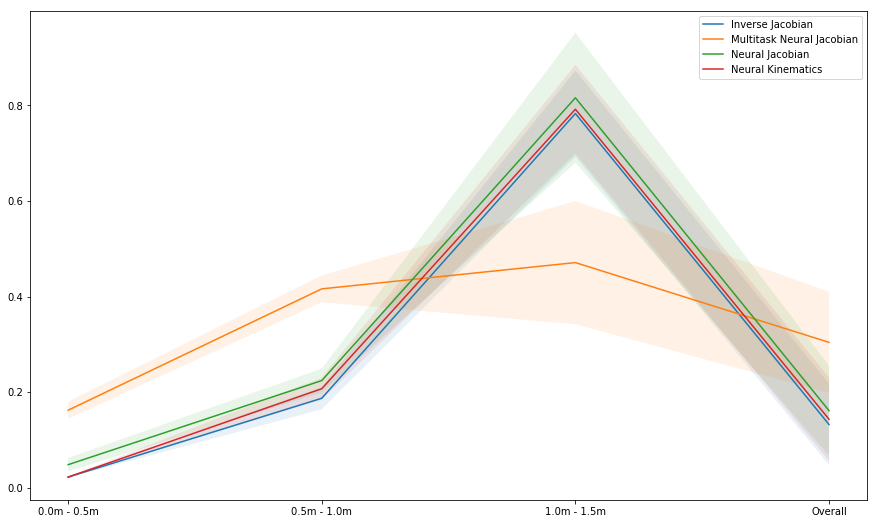

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cols = end_dist_table.columns.values
rows = end_dist_table.index.values
print(cols.tolist())
for r in rows:
    row = np.array(end_dist_table.loc[r].tolist())
    std = np.array(end_dist_table_std.loc[r].tolist())
    ax.plot(row, label = r)
    ax.fill_between(list(range(len(row))), row + std, row - std, alpha=0.1)
ax.legend()
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(cols.tolist())
print(cols.tolist())

Text(0.5, 1.0, 'AUC of Trajectories for Different UVS Algorithms')

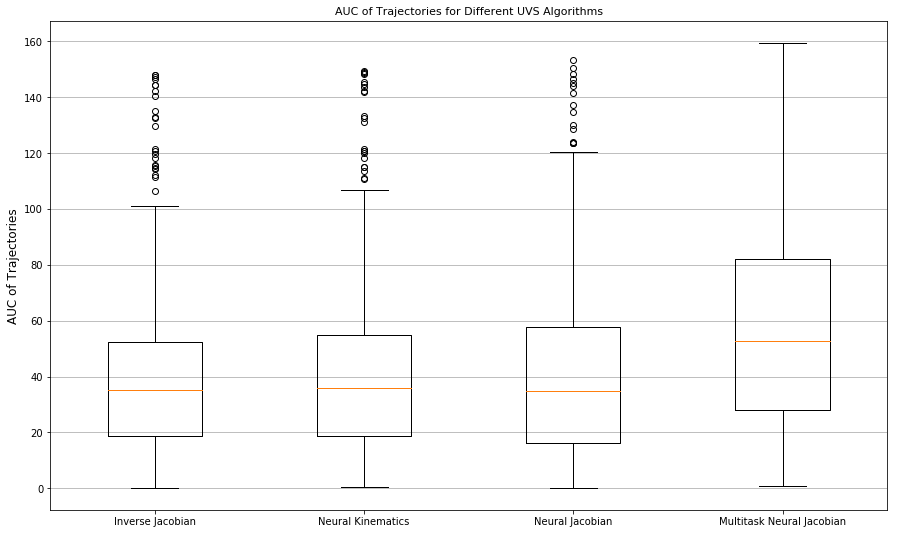

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

labels = []
aucs = []
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1) 
    #want to sum over each trajectory
    auc = err_over_time.sum(axis=0)  #for delta t between each time step
    aucs.append(auc)
    labels.append(algorithm)
    
ax.boxplot(aucs, labels=labels)

ax.yaxis.grid(True)
ax.set_ylabel("AUC of Trajectories")
ax.set_title("AUC of Trajectories for Different UVS Algorithms")

# Comparing Jacobians

Here, we just calaculate the difference between Jacobians in trajectories to see how much they differ from the true underlying Jacobian

In [56]:
def collect_jacobian_dist(result, norm=None):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2] 

            true_J = v[-1]
            if norm is not "signs":
                mse = np.linalg.norm(estimate_J - true_J, norm) #, 'fro')
            else:
                sign_mismatch = np.logical_not(np.logical_and(estimate_J, true_J))
                mse = (sign_mismatch).sum() #techinically not mind you...
            episode_err.append(mse)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [60]:
line_types = [
            ("True Jacobian", "b|-"),
            ("Local Linear", "g--"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'Local Linear', 'Broyden', 'Finite Difference', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

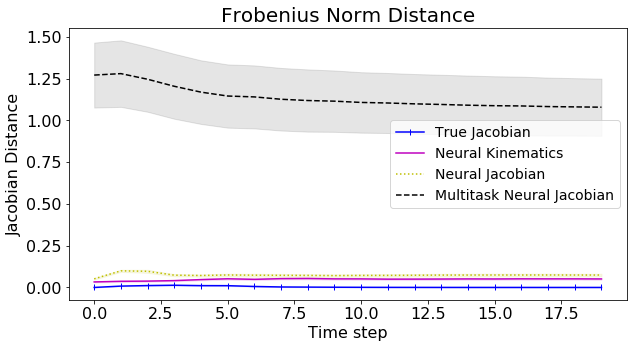

In [80]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for algorithm, result in results.items():
    jac_err = collect_jacobian_dist(result)
    line_type = line_types[algorithm]
    plot_mu_sig(jac_err[0:200:10, :], label=algorithm, ax=ax, line_stype=line_type)

    
ax.set_xlabel('Time step')
ax.set_ylabel('Jacobian Distance')
ax.set_title("Frobenius Norm Distance")
ax.legend()
plt.savefig('robo_jacobian_diff_global.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

In [62]:
#collects results for plotting histograms and trajectories
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

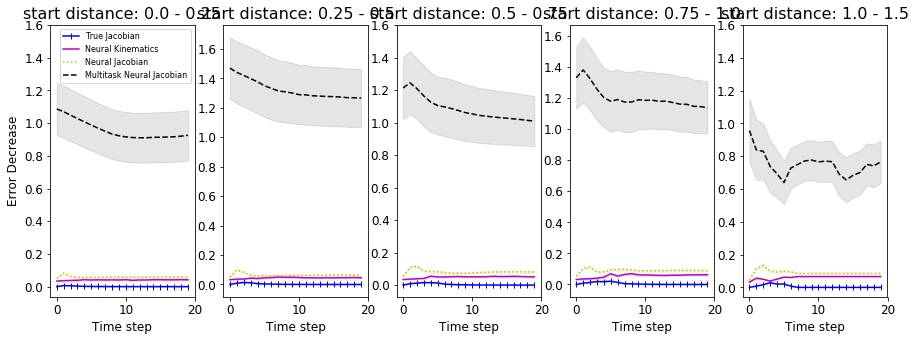

In [79]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bounds = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        line_type = line_types[algorithm]
    
        plot_mu_sig(jac_errs[algorithm][0:200:10,to_plot], label=algorithm, ax=ax, line_stype=line_type)
        
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, 1.6, 9))
    if i == 0:
        ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    ax.set_xlabel("Time step")
    if i == 0:
        ax.set_ylabel("Error Decrease")
    i += 1
    
plt.savefig('robo_jacobian_diff_by_dist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# Histograms of Jacobian difference
The previous plots were for trends over trajectories. The Jacobian differences are really independent of timesteps so to get a sense of these differences we visualize the results with histograms 


In [64]:
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

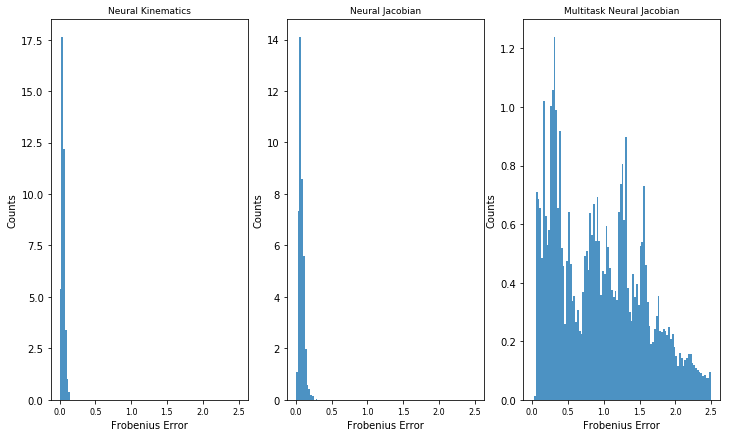

In [75]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Focusing only on the frobenius norm
fig, axs = plt.subplots(1, 3, figsize=(12, 7))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "True" in algorithm:
        continue
    ax = axs[i]
    i += 1
    jac_err = jac_err = jac_errs[algorithm]
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=100, alpha=0.8, density=True, range=(0, 2.5))
    ax.set_title(algorithm)
    ax.set_ylabel('Counts')
    #ax.get_yaxis().set_ticks([float(i)*0.1 for i in range(0, 40, 10)])
    if i == 0:
        ax.set_title("Frobenius Distance of Jacobian Approximations")
    
    #    ax.set_xticks([])
    ax.set_xlabel('Frobenius Error')

plt.savefig('robo_jacobian_hist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)  

# Checking for Criteria of Convergence
The last thing I want to check for is for whether or not the critieria on J is met for the trajectories. I will need to review this to make sure I understand it, but if JJ^{+} has any non-positive eigen values (0 or less) then hypothetically, it should not converge.

I think hypothetically JJ^{+} should be the identity matrix...and if it's not then we have problems otherwise, I'll need to read up on that. 

In [68]:
def check_pos_definite(A):
    eigs = np.linalg.eigvals(A)
            
    return (eigs > 0).all()
    
def check_jacobian_positive_definite(result, invert_true_J=False):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            
            if invert_true_J:
                iJ_hat = np.linalg.pinv(J_hat)
                JiJ = np.matmul(J, iJ_hat)
            else:
                iJ = np.linalg.pinv(J)
                JiJ = np.matmul(J_hat, iJ)
            is_pos_def = check_pos_definite(JiJ)
            loss = int(is_pos_def)
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T





In [69]:
jacobian_split = {}
for k, v in results.items():
    algorithm, result = k, v
        
    jac_err = check_jacobian_positive_definite(result)
    
    #check if criteria is met for whole trajectory or not
    always_pos_def = (jac_err.sum(axis=0) >=150)
    not_always_pos_def = (jac_err.sum(axis=0) < 150)
    
    total_traj = jac_err.shape[1]
    total_pos_d = always_pos_def.sum()
    total_not_pos_d = not_always_pos_def.sum()
    
    err_over_time = collect_eps_errs(result, dim=-1)
    traj_pos_def = err_over_time[:,always_pos_def]
    traj_not_pos_def = err_over_time[:, not_always_pos_def]
    
    jacobian_split[algorithm] = {"pos_def": traj_pos_def,
                                "not_pos_def": traj_not_pos_def,
                                 "pos_count": total_pos_d,
                                 "not_pos_count": total_not_pos_d,
                                 "total": total_traj
                                }
    

In [70]:
line_types = [
            ("True Jacobian", "b|-"),
            ("Local Linear", "g--"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'Local Linear', 'Broyden', 'Finite Difference', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


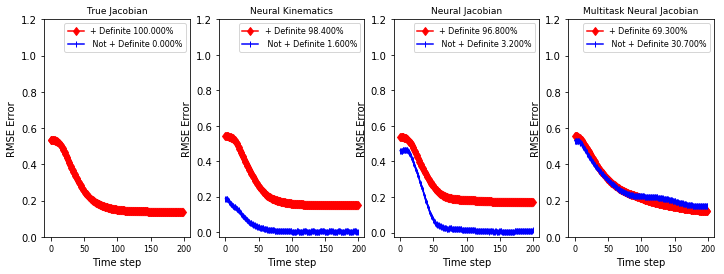

In [71]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, axs = plt.subplots(1 , 4, figsize=(12, 4))
axs = np.ndarray.flatten(axs)
#if not isinstance(axs, list):
#    axs = [axs]
i = 0
for k, v in results.items():
    algorithm, result = k, v
    #if "Inverse" in algorithm:
    #    continue
    ax = axs[i]
    i += 1

    traj_pos_def = jacobian_split[algorithm]["pos_def"]
    traj_not_pos_def = jacobian_split[algorithm]["not_pos_def"]
    total_pos_d = jacobian_split[algorithm]["pos_count"]
    total_not_pos_d = jacobian_split[algorithm]["not_pos_count"]
    total_traj =  jacobian_split[algorithm]["total"]
    #plot_mu_sig(err_over_time, label="All {} Trajectories".format(total_traj), ax=ax)
    plot_mu_sig(traj_pos_def[0:200], label="+ Definite {:.3f}%".format(round(total_pos_d / total_traj, 3) *100.0), ax=ax, line_stype="r-d")
    plot_mu_sig(traj_not_pos_def[0:200], label=" Not + Definite {:.3f}%".format(round(total_not_pos_d / total_traj, 3) *100.0), ax=ax, line_stype="b|-")
    #if i >= len(axs) - 1:
    ax.set_xlabel('Time step')
    #else:
    #    ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(0, 1.4, 0.2))
    ax.set_ylabel('RMSE Error')
    ax.set_title("{}".format(algorithm))
    ax.legend()
    
plt.savefig('robo_separate_by_pos_def.pdf',bbox_inches = 'tight',
    pad_inches = 0.1) 